##6. 각 요일의 시가에 사서 종가에 팔 때 기대수익률
####(2002.7.15 ~ 2022.7.15 까지의 data)
-----------------------------------------------------------------------
##### < 2002.7.15을 0일이라 할때 각 기간별 장의 성격 >
##### 0~260   : 하락장
##### 261~1382 : 상승장
##### 1383 ~ 1718 : 평타장
##### 1719 ~ 1941 : 상승장
##### 1942 ~ 2024 : 하락장
##### 2025 ~ 3307 : 상승장
##### 3308 ~ 5330 : 평타장
##### 5331 ~ 5771 : 상승장
##### 5772 ~ 6461 : 하락장
##### 6462 ~ 6932 : 상승장
##### 6932 ~ 7305 : 하락장


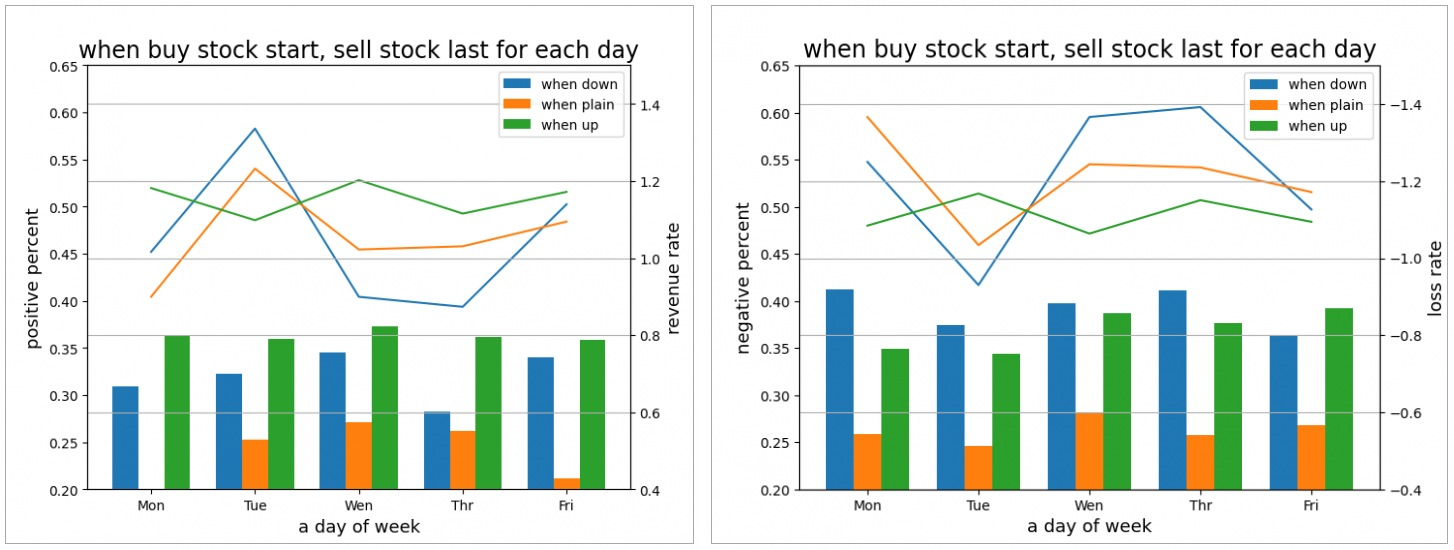

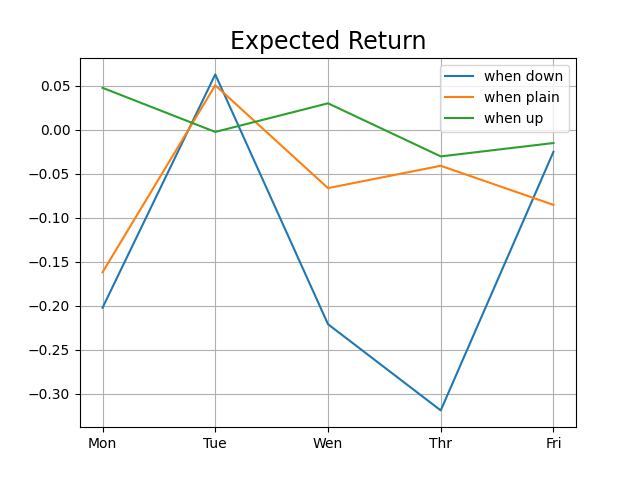

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# csv 파일을 받아서 각 column에 이름 부여
def readFile():
    input_data = pd.read_csv("KOSPI_data - 복사본.csv", names=["day","startPrice","MaxPrice","LowPrice","FinalPrice","tradeNum","tradePrice","week","algo"])
    return input_data

In [ ]:
# 가장 옛 날짜부터 data를 얻음
# 다음날짜와 현재 날짜의 차이를 구하고, 차이만큼 이전 날짜의 종가로 data를 추가로 만들어 빈 날을 채움
def getWeekData(input_data):
    index = 4947
    temp = input_data.iloc[index]
    stock_data = []

    while (index > 0):
        stock_data.append([temp[0],temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[8]])

        dayDiff = input_data.iloc[index-1][0]-temp[0]
        for i in range(1,dayDiff):
            stock_data.append([(temp[0]+i),temp[4],temp[4],temp[4],temp[4],0,0,""])
        
        index -= 1
        temp = input_data.iloc[index]
    stock_data.append([temp[0],temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[8]])
            
    return stock_data

In [ ]:
# 미리 정해놓은 기간의 장의 성격에 따른 각 요일별 평균 시가와 종가를 구함
def getStaticAvr(stock_data, type):
    # 하락장, 평타장, 상승장 구분을 위한 기간(날짜단위) , (하락장:0, 평타장:1, 상승장:2)
    marketType=[[[0,260],     [1942,2024], [5772,6461], [6932,7305]],
                [[1383,1718], [3308,5330]],
                [[261, 1382], [1719,1941], [2025,3307], [5331,5771], [6462,6932]]]
    
    sumSW = [0,0,0,0,0]
    avrSW = [0,0,0,0,0]
    sumLW = [0,0,0,0,0]
    avrLW = [0,0,0,0,0]
    WeekS = []
    WeekL = []
    weekcnt=0

    # 각 장의 성격에 따라 장의 시작 주와 끝 주 저장
    for i in range(0,len(marketType[type])):
        WeekS.append(marketType[type][i][0]//7)
        WeekL.append(marketType[type][i][1]//7)
        weekcnt+=(WeekL[i]-WeekS[i])
        
    # 각 주의 요일별 시가,종가를 SUM
    for k in range(0,len(marketType[type])):
        for i in range(WeekS[k],WeekL[k]) :
            for j in range(0,5):
                sumSW[j]+=stock_data[i*7+j][1]
                sumLW[j]+=stock_data[i*7+j][4]
    
    # 각 요일별 평균을 구함 (각 요일별 합을 기간 중 일주일의 수로 나눔)
    for i in range(0,5):
        avrSW[i] = sumSW[i]/weekcnt
        avrLW[i] = sumLW[i]/weekcnt
    
    return avrSW, avrLW

In [ ]:
# 사용자가 임의로 지정한 기간의 각 요일별 평균 시가와 종가를 구함
def getDynamicAvr(stock_data, startW, lastW):
    sumSW = [0,0,0,0,0]
    avrSW = [0,0,0,0,0]
    sumLW = [0,0,0,0,0]
    avrLW = [0,0,0,0,0]
    weekcnt= lastW - startW
        
    # 각 주의 요일별 시가,종가를 SUM
    for i in range(startW,lastW) :
        for j in range(0,5):
            sumSW[j]+=stock_data[i*7+j][1]
            sumLW[j]+=stock_data[i*7+j][4]
    
    # 각 요일별 평균을 구함 (각 요일별 합을 기간 중 일주일의 수로 나눔)
    for i in range(0,5):
        avrSW[i] = sumSW[i]/weekcnt
        avrLW[i] = sumLW[i]/weekcnt
    
    return avrSW, avrLW

In [ ]:
# 장의 성격에 따른 각 요일별 [ 승리수, 패배수 , 수익률, 손실률]
logicDataSum = [[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],
                [0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],
                [0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0]]

# 기간에 따라 시가에 사서 종가에 팔 때 data를 logicDataSum에 저장
def divideCase(s,l ,stock_data, type):
    global logicDataSum
    tempdata =[[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0],[0,0,0.0 , 0.0] ]
    for i in range(s,l):
        for j in range(0,5):
            # 그날의 (종가 - 시가) / 시가  (날마다 돈의 차이가 있기 때문에 비율로 비교하기 위해 나눔)
            gap = 100*(stock_data[i*7+j][4]-stock_data[i*7+j][1])/stock_data[i*7+j][1]
            if(gap >0):
                tempdata[j][0]+=1
                tempdata[j][2]+=gap
            elif (gap <0) :
                tempdata[j][1]+=1
                tempdata[j][3]+=gap

    for i in range(0,5):
        for j in range(0,4):
            logicDataSum[5*type + i][j]+=tempdata[i][j]
    
    print("기간", s, "~", l)        
    print("월", tempdata[0][0], tempdata[0][1], tempdata[0][2]/tempdata[0][0] , tempdata[0][3]/tempdata[0][1])
    print("화", tempdata[1][0], tempdata[1][1], tempdata[1][2]/tempdata[1][0] , tempdata[1][3]/tempdata[1][1])
    print("수", tempdata[2][0], tempdata[2][1], tempdata[2][2]/tempdata[2][0] , tempdata[2][3]/tempdata[2][1])
    print("목", tempdata[3][0], tempdata[3][1], tempdata[3][2]/tempdata[3][0] , tempdata[3][3]/tempdata[3][1])
    print("금", tempdata[4][0], tempdata[4][1], tempdata[4][2]/tempdata[4][0] , tempdata[4][3]/tempdata[4][1])

In [ ]:
# 각 장에 따라 기간을 넣어 data를 얻게 함
def doLogic(type):
    global logicDataSum
    stock_data = getWeekData(readFile())
    
    if(type == 0):
        print("<하락장>")
        divideCase(0,260//7,stock_data,0)
        divideCase(1942//7,2024//7,stock_data,0)
        divideCase(5772//7,6461//7,stock_data,0)
        divideCase(6932//7,7305//7,stock_data,0)
    elif(type == 1):
        print("<평타장>")
        divideCase(1383//7,1718//7,stock_data,1)
        divideCase(3308//7,5330//7,stock_data,1)

    elif(type == 2):
        print("<상승장>")
        divideCase(261//7,1382//7,stock_data,2)
        divideCase(1719//7,1941//7,stock_data,2)
        divideCase(2025//7,3307//7,stock_data,2)
        divideCase(5331//7,5771//7,stock_data,2)
        divideCase(6462//7,6932//7,stock_data,2)
    print("")

    # 수익률,손실률의 합들을 수만큼 나눠 평균을 얻음
    for i in range(0,5):
        logicDataSum[5*type + i][2] /= logicDataSum[5*type + i][0]
        logicDataSum[5*type + i][3] /= logicDataSum[5*type + i][1]
   
    print("<최종>")
    print("월", logicDataSum[5*type + 0][0], logicDataSum[5*type + 0][1], logicDataSum[5*type + 0][2] , logicDataSum[5*type + 0][3])
    print("화", logicDataSum[5*type + 1][0], logicDataSum[5*type + 1][1], logicDataSum[5*type + 1][2] , logicDataSum[5*type + 1][3])
    print("수", logicDataSum[5*type + 2][0], logicDataSum[5*type + 2][1], logicDataSum[5*type + 2][2] , logicDataSum[5*type + 2][3])
    print("목", logicDataSum[5*type + 3][0], logicDataSum[5*type + 3][1], logicDataSum[5*type + 3][2] , logicDataSum[5*type + 3][3])
    print("금", logicDataSum[5*type + 4][0], logicDataSum[5*type + 4][1], logicDataSum[5*type + 4][2] , logicDataSum[5*type + 4][3])

In [ ]:
# type 0: 수익이 있을 때 , 1: 손실이 있을 때
def drawGraph(type):

    percentValues= [[.0,.0,.0,.0,.0],
                    [.0,.0,.0,.0,.0],
                    [.0,.0,.0,.0,.0]]
    
    getMoneys= [[.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0]]
    
    # type에 따라 승률 또는 패율 계산
    for i in range(0,3):
        for j in range(0,5):
            percentValues[i][j] = logicDataSum[i*5+j][type]/ (logicDataSum[i*5+j][0]+logicDataSum[i*5+j][1])

    # type에 따라 수익률 또는 손실률 저장
    for i in range(0,3):
        for j in range(0,5):
            getMoneys[i][j] = logicDataSum[i*5+j][type+2]


    # 그래프 그리기
    ylabel1=""
    ylabel2=""
    ylim=[]
    if(type ==0):
        ylabel1="positive percent"
        ylabel2="revenue rate"
        ylim = [0.4,1.5]
    elif(type==1):
        ylabel1="negative percent"
        ylabel2="loss rate"
        ylim = [-0.4,-1.5]

    fig, ax1 = plt.subplots()
    index = np.arange(5)

    # 승률 또는 패율 graph
    ax1.plot(index+0.25,percentValues[0],label="when down")
    ax1.plot(index+0.25,percentValues[1],label="when plain")
    ax1.plot(index+0.25,percentValues[2],label="when up")
    ax1.set_xlabel('a day of week', size = 13)
    ax1.set_ylabel(ylabel1, size = 13)
    ax1.set_ylim([0.2,0.65])


    # 수익률 또는 손실률 graph
    ax2 = ax1.twinx()
    
    ax2.bar(index+0,   getMoneys[0],0.25, label="when down")
    ax2.bar(index+0.25,getMoneys[1],0.25, label="when plain")
    ax2.bar(index+0.5, getMoneys[2],0.25, label="when up")
    ax2.set_ylabel(ylabel2, size = 13)
    ax2.set_ylim(ylim)

    plt.xticks(np.arange(0.25,5+0.25),["Mon","Tue","Wen","Thr","Fri"])
    plt.title("when buy stock start, sell stock last for each day",size = 17)
    plt.legend()
    plt.grid('on')
    plt.show()

In [ ]:
# 기대 수익률 그래프
def expReturnGraph():
    data = [[.0,.0,.0,.0,.0],
            [.0,.0,.0,.0,.0],
            [.0,.0,.0,.0,.0]]
    
    for i in range(0,3):
        for j in range(0,5):
            data[i][j] = (logicDataSum[5*i+j][0]/(logicDataSum[5*i+j][0]+logicDataSum[5*i+j][1])) * logicDataSum[5*i+j][2] + (logicDataSum[5*i+j][1]/(logicDataSum[5*i+j][0]+logicDataSum[5*i+j][1])) * logicDataSum[5*i+j][3] 
    
    index = np.arange(5)
    plt.plot(index,data[0],label="when down")
    plt.plot(index,data[1],label="when plain")
    plt.plot(index,data[2],label="when up")
    plt.xticks(np.arange(0,5),["Mon","Tue","Wen","Thr","Fri"])
    plt.title("Expected Return",size = 17)
    plt.legend()
    plt.grid('on')
    plt.show()

In [ ]:
def ExpReturnPrint():
    print("기대수익률 = 승률*수익률 + 패율*손실률")
    print("하락장일 때 기대 수익률")
    for i in range(0,5):
        print((logicDataSum[0+i][0]/(logicDataSum[0+i][0]+logicDataSum[0+i][1])) * logicDataSum[0+i][2] + (logicDataSum[0+i][1]/(logicDataSum[0+i][0]+logicDataSum[0+i][1])) * logicDataSum[0+i][3] )
    
    print("")
    print("평타장일 때 기대 수익률")
    for i in range(0,5):
        print((logicDataSum[5+i][0]/(logicDataSum[5+i][0]+logicDataSum[5+i][1])) * logicDataSum[5+i][2] + (logicDataSum[5+i][1]/(logicDataSum[5+i][0]+logicDataSum[5+i][1])) * logicDataSum[5+i][3] )

    print("")
    print("상승장일 때 기대 수익률")
    for i in range(0,5):
        print((logicDataSum[10+i][0]/(logicDataSum[10+i][0]+logicDataSum[10+i][1])) * logicDataSum[10+i][2] + (logicDataSum[10+i][1]/(logicDataSum[10+i][0]+logicDataSum[10+i][1])) * logicDataSum[10+i][3] )



In [ ]:
def main():
    doLogic(0)  # 하락장
    doLogic(1)  # 평타장
    doLogic(2)  # 상승장

    #ExpReturnPrint()
    expReturnGraph()

    # 0 이면 승률,수익률 , 1이면 패율,손실률
    #drawGraph(0)

main()